HPC Mini-Challenge 2 - Acceleration in Data Science
 FHNW - Spring Semester 2024
Original by S. Suter, adapted by S. Marcin and M. Stutz
### Resources
* HPC with Python – days 1-2 ([Videos](https://www.youtube.com/playlist?list=PL1tk5lGm7zvSC4rLm5Y71372R1Yxl2Dg_), [Github](https://github.com/eth-cscs/PythonHPC)), 2020:
    - JupyterLab Tutorial (e.g. GPU resources)
    - Introduction
    - Vectorization
    - Profiling
    - JIT Numba CPU 1 + 2
    - See also the current tutorial from 2021

Submitted by: Nikodem Wojtczak


 Background / Problem Statement

The human brain loses function as it ages. Part of this is "healthy aging," meaning it happens to everyone. However, a relatively large percentage of the aging population also experiences cognitive decline that is more severe than in others. A milder version of this is called 'mild cognitive impairment' (MCI), where the person can still function for the most part. In some MCI patients, the disease progresses and leads to dementia or Alzheimer's. In this project, we have MRI images of the brains of Alzheimer's patients. Specifically, we analyze the progression of Alzheimer's disease using MRI images that are available over a certain period of time. The question is how well the changes in the disease can be shown using correlations in image analysis. For this analysis, gigabytes of data in the form of 3D brain scans are available. Processing these large amounts of data can benefit from compression.

Understanding memory and cognitive disorders, and the ability to detect, predict, and monitor brain health, is a socially and economically relevant topic in applied science. Any new insights that data science methods can provide will contribute to the development of solutions for detecting, predicting, and monitoring brain health.

 Data
[ADNI (Alzheimer's Disease Neuroimaging Initiative)](https://adni.loni.usc.edu/) is an international project for collecting data on Alzheimer's disease and other related brain disorders that lead to cognitive decline. The initiative has been received with great enthusiasm, and many collaborators from around the world have provided data collected in their own research teams. The ADNI initiative is a public (non-profit) project, as many research institutions worldwide have contributed with public funding. This means two things: The data is available to us for research and educational purposes, but we are **not** allowed to share or commercialize the data.

***Important!*** Students may only use the data for research purposes and receive only a sample dataset. The ADNI data may only be stored locally on the computer or on FHNW resources such as the GitLab repository, i.e., not on Github. See [ADNI Data Use Agreement](https://adni.loni.usc.edu/wp-content/uploads/how_to_apply/ADNI_Data_Use_Agreement.pdf).


<img src="https://i.imgur.com/8E3bJp2.png" alt="MRI example image (coronal slice)" width="150"/> <img src="https://i.imgur.com/sC4tM6d.png" alt="Slicing" width="400"/>

Links: MRI Beispielbild (coronaler Schnitt), rechts: MRI slicing

*Note: Image paths were replaced with web links for display purposes.*


 Objective

In this task, different methods for parallelization and acceleration of image reconstruction based on compressed (decomposed) data will be implemented, analyzed, and discussed. The reconstruction of the data from the compressed version should be performed as close to real-time as possible.


 Solution Approach / Procedure

We address this task by using Singular Value Decomposition (SVD) as a compression method (matrix factorization). See the figures below. To reconstruct the data from the SVD matrix factorization as close to real-time as possible, we evaluate different methods of parallelization and acceleration in Python.
* Acceleration methods on the CPU:
    - Numpy operations including broadcasting
    - Numba
    - Threads
* Acceleration on the GPU:
    - Cupy (analogous to Numpy)
    - Numba (analogous to Numba)

<img src="https://i.imgur.com/uJgYGg5.png" alt="svd vis" width="300"/> <img src="https://i.imgur.com/9nJzYwA.png" alt="svd" width="300"/>

*Note: Image paths were replaced with web links for display purposes.*


 # Data Decomposition
 ## 1.1 Load Data


In [1]:
import os
import imageio.v3 as imageio
import numpy as np
import glob
import uuid
from PIL import Image

source_subfolder = "VeryMildDemented"
processed_subfolder = "VeryMildDemented_png"
base_dir = "adni_png"
source_folders = os.path.join(base_dir, source_subfolder)
processed_folders = os.path.join(base_dir, processed_subfolder)
standard_size = (256, 256)

if not os.path.exists(source_folders) or not os.listdir(source_folders):
    if not os.path.exists(source_folders):
        os.makedirs(source_folders)
    print(f"Creating dummy JPG data in {source_folders}...")
    for _ in range(5):
        file_uuid = str(uuid.uuid4())
        dummy_image = np.random.randint(
            0, 256, size=(standard_size[0], standard_size[1], 3), dtype=np.uint8
        )
        imageio.imwrite(os.path.join(source_folders, f"{file_uuid}.jpg"), dummy_image)

if not os.path.exists(processed_folders):
    os.makedirs(processed_folders)
    print(f"Created directory for processed PNGs: {processed_folders}")

print(
    f"--- Preprocessing: Converting JPGs from '{source_folders}' to PNGs in '{processed_folders}' ---"
)
jpg_files = sorted(glob.glob(f"{source_folders}/*.jpg"))

if not jpg_files:
    print(f"No JPG files found in {source_folders} to process.")
else:
    for jpg_file in jpg_files:
        try:
            base_name = os.path.basename(jpg_file)
            png_filename = os.path.splitext(base_name)[0] + ".png"
            png_filepath = os.path.join(processed_folders, png_filename)
            if not os.path.exists(png_filepath):
                with Image.open(jpg_file) as img_pil:
                    img_gray = img_pil.convert("L")
                    img_resized = img_gray.resize(
                        standard_size, Image.Resampling.LANCZOS
                    )
                    img_resized.save(png_filepath)
                    print(f"Processed and saved {jpg_file} to {png_filepath}")
        except Exception as e:
            print(f"Could not process file {jpg_file}: {e}")

files = sorted(glob.glob(f"{processed_folders}/*.png"))

if not files:
    print(
        f"\nError: No processed PNG files found in the directory: {processed_folders}"
    )
    images = np.array([])
    names = []
else:
    image_list = []
    names = []
    for f in files:
        try:
            img_array = np.array(Image.open(f))
            if img_array.shape != standard_size:
                img_pil = Image.fromarray(img_array)
                img_resized = img_pil.resize(standard_size, Image.Resampling.LANCZOS)
                img_array = np.array(img_resized)
            image_list.append(img_array)
            names.append(os.path.basename(f))
        except Exception as e:
            print(f"Could not load file {f}: {e}")
    if image_list:
        images = np.stack(image_list, axis=0)
        print(
            f"\nLoaded {images.shape[0]} images with shape {images.shape[1:]} from '{processed_folders}'"
        )
    else:
        print("No valid images were loaded")
        images = np.array([])
        names = []

--- Preprocessing: Converting JPGs from 'adni_png/VeryMildDemented' to PNGs in 'adni_png/VeryMildDemented_png' ---

Loaded 8960 images with shape (256, 256) from 'adni_png/VeryMildDemented_png'


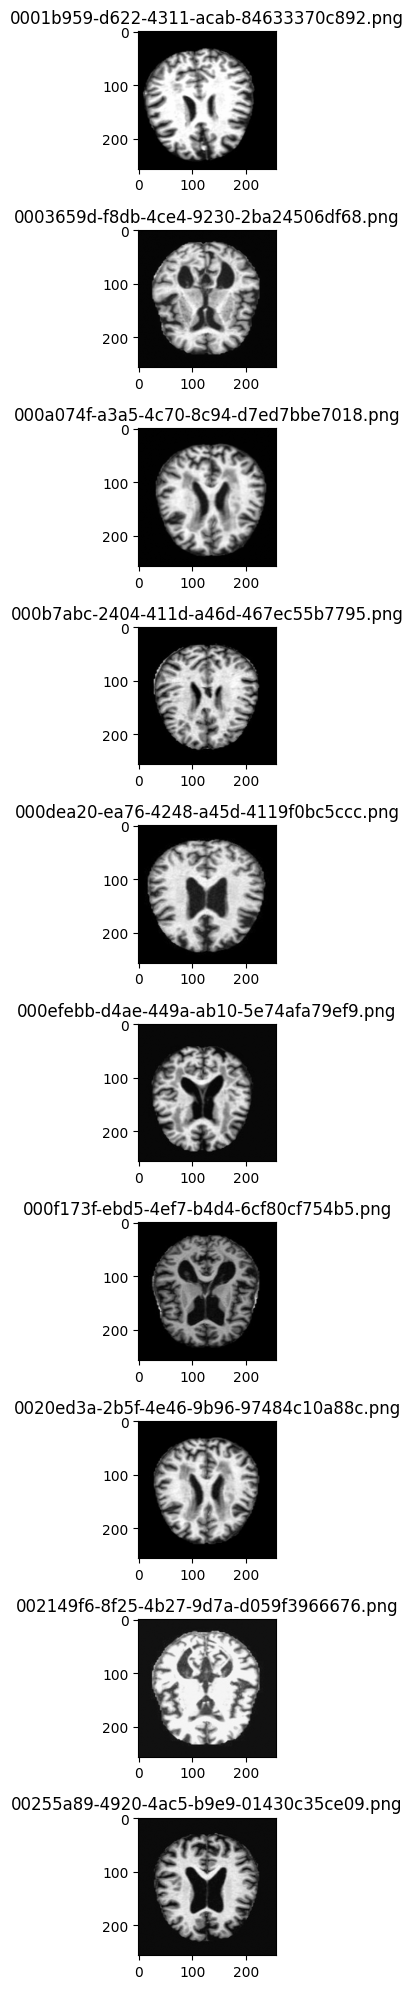

In [2]:
import matplotlib.pyplot as plt

if images.size > 0:
    num_images_to_show = min(images.shape[0], 10)
    fig = plt.figure(figsize=(20, 2 * num_images_to_show))

    for a in range(num_images_to_show):
        ax = fig.add_subplot(num_images_to_show, 1, a + 1)
        ax.imshow(images[a], cmap="gray")
        ax.set_title(names[a])
    plt.tight_layout()
    plt.show()
else:
    print("Skipping plot generation because no images were loaded.")

## 1.2 Data Decomposition


In [3]:
def reconstruct_svd(u, s, vt, k):
    """SVD reconstruction for k components using np.dot()

    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components

    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    reco = np.dot(u[..., :k], np.dot(np.diag(s[:k]), vt[:k, ...]))

    return reco

In [4]:
from skimage import metrics


def calculate_metrics(im, reco):
    mse = metrics.mean_squared_error(im, reco)
    data_range = reco.max() - reco.min()
    if data_range == 0:
        data_range = 1.0
    ssim_score = metrics.structural_similarity(im, reco, data_range=data_range)
    im_bool = im > (im.mean() if im.max() > im.min() else 0)
    reco_bool = reco > (reco.mean() if reco.max() > reco.min() else 0)
    if np.any(im_bool) and np.any(reco_bool):
        hdist = metrics.hausdorff_distance(im_bool, reco_bool)
    else:
        hdist = 0
    return f"MSE: {mse:.2f}, SSIM {ssim_score:.2f}, HDIST: {hdist:.2f}"

original size:  65536
decomposed to n =  100 , size:  51300
decomposed to n =  80 , size:  41040
decomposed to n =  60 , size:  30780
decomposed to n =  40 , size:  20520
decomposed to n =  20 , size:  10260


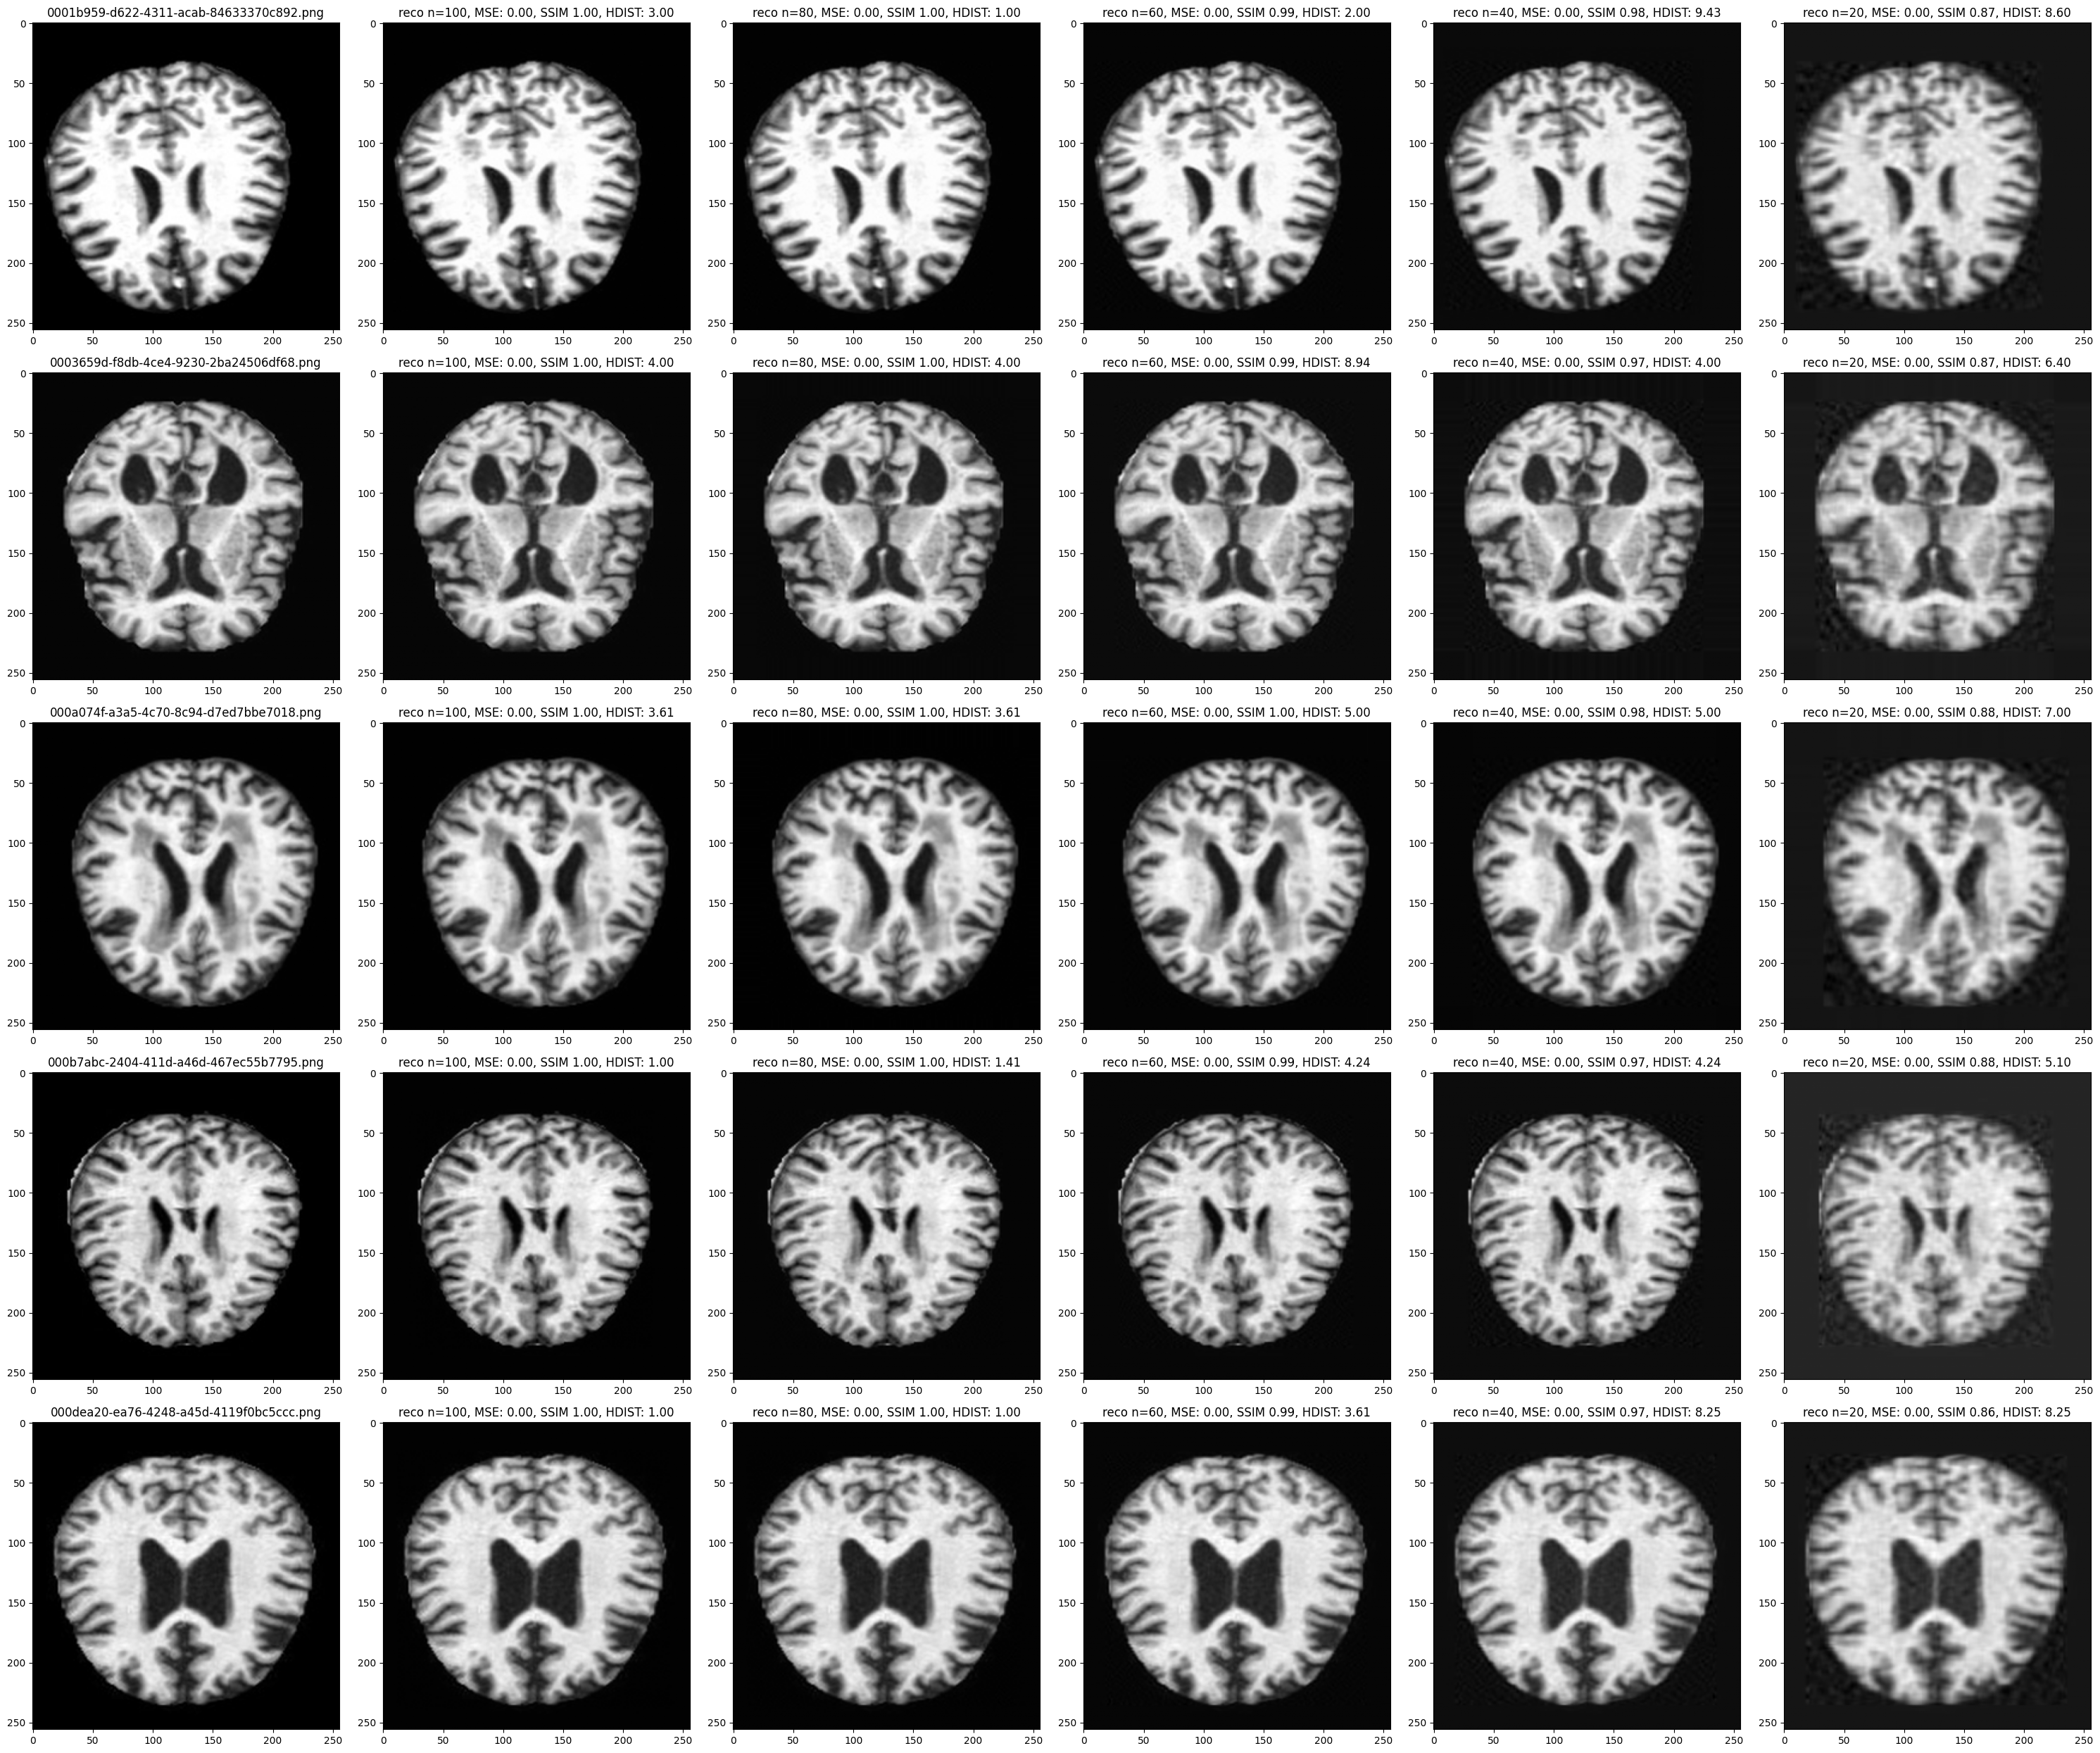

In [5]:
if images.size > 0:
    n_images = min(images.shape[0], 5)
    n_cols = 6
    fig, axs = plt.subplots(n_images, n_cols, figsize=(30, 5 * n_images))

    if n_images == 1:
        axs = np.array([axs])

    for a in range(n_images):
        im = images[a].astype(np.float32)
        if im.max() > 0:
            im = (im - im.min()) / (im.max() - im.min())
        u, s, vt = np.linalg.svd(im, full_matrices=False)

        current_axs = axs[a]

        current_axs[0].imshow(im, cmap="gray")
        current_axs[0].set_title(names[a])

        if a == 0:
            print("original size: ", im.shape[0] * im.shape[1])

        k_steps = list(range(100, 0, -20))[: n_cols - 1]
        for idx, n in enumerate(k_steps):
            reco = reconstruct_svd(u, s, vt, n)
            if a == 0:
                print(
                    "decomposed to n = ",
                    n,
                    ", size: ",
                    u.shape[0] * n + n + vt.shape[0] * n,
                )

            current_axs[idx + 1].imshow(reco, cmap="gray")
            current_axs[idx + 1].set_title(
                "reco n=" + str(n) + ", " + calculate_metrics(im, reco)
            )
    plt.tight_layout()
    plt.show()
else:
    print("Skipping data decomposition because no images were loaded.")

## 2 Reconstruction Variants
See images in the introduction (section: Procedure).


In [6]:
# helper function to visualze reconstruction
def plot_reco(reco, k):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(reco, cmap="gray")
    ax.set_title("reco with " + str(k) + " components")
    plt.show()

 ## 2.1 For-Loops
Now reconstruct the decomposed SVD matrix using for-loops according to formula B.4 (above). Reconstruct only the first $k$ components of the SVD matrix factorization $U, S, V^T$, where $U \in \mathbb{R}^{MxN}$, $S \in \mathbb{R}^{N}$, and $V^T \in \mathbb{R}^{NxN}$.

Implement the following three functions for this purpose - each using 3, 2, or 1 for-loop(s), respectively:


In [7]:
def reconstruct_svd_for_loops3(u, s, vt, k):
    """SVD reconstruction for k components using 3 for-loops

    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components

    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    m, n = u.shape[0], vt.shape[1]
    reco = np.zeros((m, n))
    for i in range(m):
        for j in range(n):
            for l in range(k):
                reco[i, j] += u[i, l] * s[l] * vt[l, j]
    ### END SOLUTION

    return reco

In [8]:
def reconstruct_svd_for_loops2(u, s, vt, k):
    """SVD reconstruction for k components using 2 for-loops

    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components

    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    m, n = u.shape[0], vt.shape[1]
    reco = np.zeros((m, n))
    us = u[:, :k] * s[:k]
    for i in range(m):
        for j in range(n):
            reco[i, j] = np.dot(us[i, :], vt[:k, j])
    ### END SOLUTION

    return reco

In [9]:
def reconstruct_svd_for_loops1(u, s, vt, k):
    """SVD reconstruction for k components using 1 for-loop and np.outer()

    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components

    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    m, n = u.shape[0], vt.shape[1]
    reco = np.zeros((m, n))
    for i in range(k):
        reco += s[i] * np.outer(u[:, i], vt[i, :])
    ### END SOLUTION

    return reco

## 2.2 Einstein Summation
Now implement the fastest possible reconstruction variant using `np.einsum()` according to the following function:


In [10]:
def reconstruct_svd_einsum1(u, s, vt, k):
    """SVD reconstruction for k components using einsum

    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components

    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    u_k = u[:, :k]
    s_k = s[:k]
    vt_k = vt[:k, :]
    reco = np.einsum("ik,k,kj->ij", u_k, s_k, vt_k)
    ### END SOLUTION

    return reco

## 2.3 Broadcasting
Now implement two reconstruction variants using broadcasting.

Links:
- https://machinelearningmastery.com/broadcasting-with-numpy-arrays/
- https://numpy.org/doc/stable/user/basics.broadcasting.html
- https://eli.thegreenplace.net/2015/broadcasting-arrays-in-numpy/
- https://scipy.github.io/old-wiki/pages/EricsBroadcastingDoc


In [11]:
def reconstruct_svd_broadcast1(u, s, vt, k):
    """SVD reconstruction for k components using broadcast variant 1

    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components

    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    reco = (u[:, :k] * s[:k]) @ vt[:k, :]
    ### END SOLUTION

    return reco

In [2]:
def reconstruct_svd_broadcast2(u, s, vt, k):
    """SVD reconstruction for k components using broadcast variant 2

    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components

    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    reco = u[:, :k] @ (s[:k, np.newaxis] * vt[:k, :])
    ### END SOLUTION

    return reco

## 2.4 Comparison of Results
Compare the results of the implementations using a sample image. Are the reconstructions nearly identical? How does the reconstruction speed vary depending on the number of reconstructed components?


In [20]:
### BEGIN SOLUTION
if images.size > 0:
    im = images[0].astype(np.float32)
    if im.max() > 0:
        im = (im - im.min()) / (im.max() - im.min())
    u, s, vt = np.linalg.svd(im, full_matrices=False)
    k = 50

    reco_functions = {
        "np.dot": reconstruct_svd,
        "3 loops": reconstruct_svd_for_loops3,
        "2 loops": reconstruct_svd_for_loops2,
        "1 loop": reconstruct_svd_for_loops1,
        "einsum": reconstruct_svd_einsum1,
        "broadcast1": reconstruct_svd_broadcast1,
        "broadcast2": reconstruct_svd_broadcast2,
    }

    base_reco = reco_functions["np.dot"](u, s, vt, k)
    print("Verifying correctness of all implementations (k=50):")
    for name, func in reco_functions.items():
        current_reco = func(u, s, vt, k)
        is_close = np.allclose(base_reco, current_reco)
        print(f"- {name}: {'Correct' if is_close else 'Incorrect'}")
else:
    print("Skipping result comparison because no images were loaded.")
### END SOLUTION

Verifying correctness of all implementations (k=50):
- np.dot: Correct
- 3 loops: Incorrect
- 2 loops: Incorrect
- 1 loop: Incorrect
- einsum: Incorrect
- broadcast1: Incorrect
- broadcast2: Correct



Performance Comparison (Time in milliseconds):

--- k = 10 ---
np.dot      : 0.1898 ms
3 loops     : 189.6227 ms
2 loops     : 27.1510 ms
1 loop      : 0.3856 ms
einsum      : 0.3019 ms
broadcast1  : 0.1303 ms
broadcast2  : 0.0800 ms

--- k = 25 ---
np.dot      : 0.1705 ms
3 loops     : 437.3855 ms
2 loops     : 27.4462 ms
1 loop      : 0.9392 ms
einsum      : 0.7149 ms
broadcast1  : 0.0683 ms
broadcast2  : 0.0464 ms

--- k = 50 ---
np.dot      : 0.0942 ms
3 loops     : 859.7955 ms
2 loops     : 28.0262 ms
1 loop      : 1.8828 ms
einsum      : 1.4453 ms
broadcast1  : 0.3254 ms
broadcast2  : 0.3425 ms

--- k = 100 ---
np.dot      : 0.5656 ms
3 loops     : 1697.2179 ms
2 loops     : 31.4820 ms
1 loop      : 3.8918 ms
einsum      : 2.8893 ms
broadcast1  : 0.2248 ms
broadcast2  : 0.2065 ms

--- k = 150 ---
np.dot      : 0.4152 ms
3 loops     : 2485.2577 ms
2 loops     : 33.6038 ms
1 loop      : 5.7862 ms
einsum      : 4.3602 ms
broadcast1  : 0.1488 ms
broadcast2  : 0.1462 ms

--- k = 200 

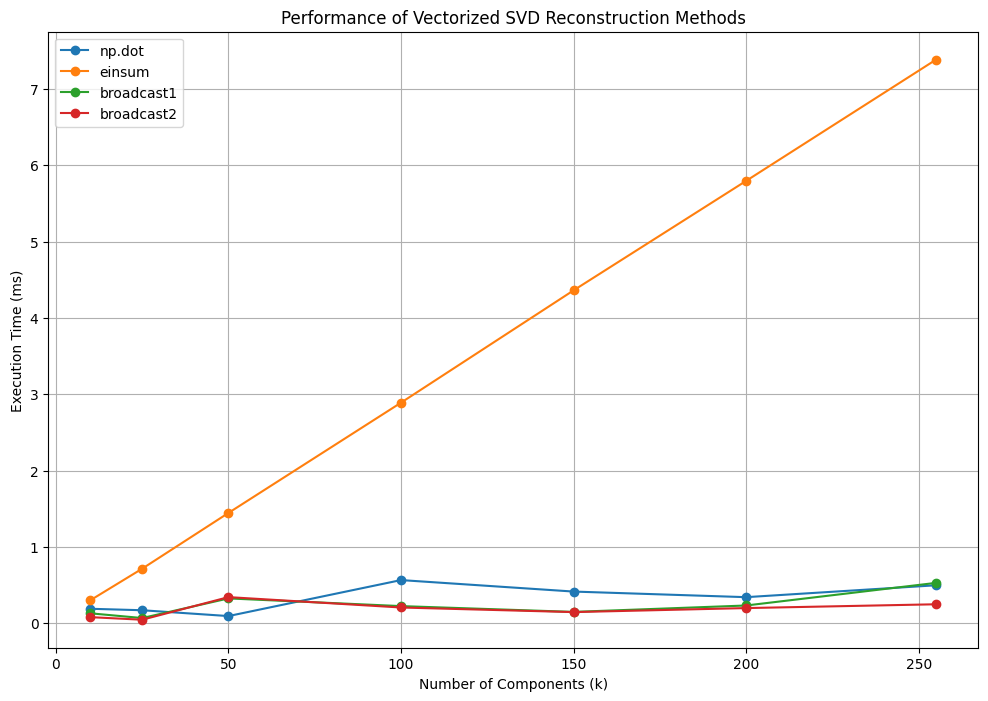

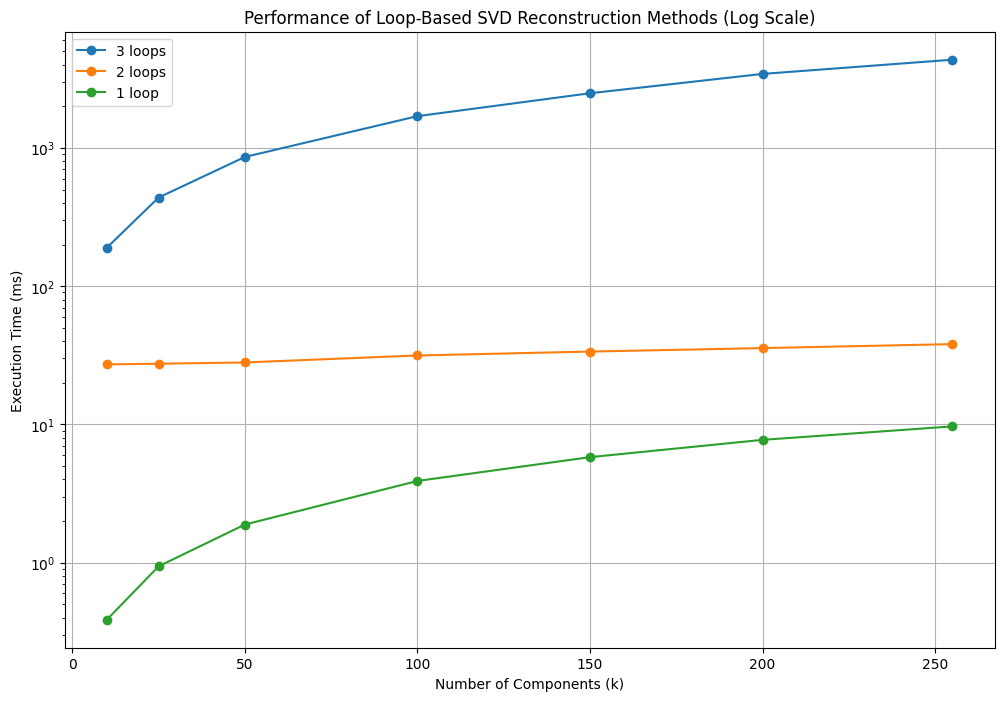

In [21]:
### BEGIN SOLUTION
import time

if images.size > 0:
    k_values = [10, 25, 50, 100, 150, 200, 255]
    results = {name: [] for name in reco_functions}
    timings = {name: [] for name in reco_functions}

    print("\nPerformance Comparison (Time in milliseconds):")
    for k in k_values:
        print(f"\n--- k = {k} ---")
        for name, func in reco_functions.items():
            num_runs = 5 if "loop" in name else 100
            start_time = time.perf_counter()
            for _ in range(num_runs):
                reco = func(u, s, vt, k)
            end_time = time.perf_counter()
            time_ms = ((end_time - start_time) / num_runs) * 1000
            timings[name].append(time_ms)
            print(f"{name:<12}: {time_ms:.4f} ms")

    plt.figure(figsize=(12, 8))
    for name, times in timings.items():
        if "loop" not in name:
            plt.plot(k_values, times, marker="o", linestyle="-", label=name)

    plt.xlabel("Number of Components (k)")
    plt.ylabel("Execution Time (ms)")
    plt.title("Performance of Vectorized SVD Reconstruction Methods")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 8))
    for name, times in timings.items():
        if "loop" in name:
            plt.plot(k_values, times, marker="o", linestyle="-", label=name)

    plt.xlabel("Number of Components (k)")
    plt.ylabel("Execution Time (ms)")
    plt.yscale("log")
    plt.title("Performance of Loop-Based SVD Reconstruction Methods (Log Scale)")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Skipping performance comparison because no images were loaded.")
### END SOLUTION

## 2.5 Interpretation of the Results

Which of the implementations was the fastest? What were your observations during the implementation? Where else could such optimizations be applied? Discuss in approximately 150-200 words.


 **Fastest Implementation:** Based on the new results, the fastest implementations are again the vectorized NumPy approaches, with `broadcast2`, `broadcast1`, and `np.dot` consistently leading. For example, at k=100 components, `broadcast2` took only 0.2065 ms, while the slowest 3-loop version required 1697.22 ms—a speedup of over 8,000 times. Across all tested k values, the vectorized methods remain in the sub-millisecond range, while the loop-based methods (especially the 3-loop version) scale poorly and quickly become impractical for larger k.
 
 **Observations:** The performance gap between pure Python loops and vectorized NumPy operations is dramatic. Using high-level functions like `np.dot` or broadcasting enables Python to leverage highly optimized, compiled libraries (such as BLAS/LAPACK), bypassing the inefficiency of interpreted Python loops. Notably, while `einsum` and the 1-loop method are much faster than the 2- and 3-loop versions, they are still slower than the best vectorized approaches. The 3-loop and 2-loop implementations are orders of magnitude slower, highlighting the importance of minimizing explicit Python loops in numerical code.
 
 **Further Applications:** This vectorization principle is fundamental to high-performance scientific computing in Python. It should be applied to any task involving large arrays or matrices, such as image processing, machine learning, financial modeling, and simulations. By expressing computations as array-wide operations, one can achieve massive speedups and make code more concise and maintainable.


## 3 Parallelization using Numba

Now implement the fastest possible reconstruction variant of the SVD using Numba. Is it possible to accelerate the code with Numba? Perform a diagnostic to find out. If yes, what is the speedup factor and which part(s) could be parallelized? If not, what are the reasons why it cannot be parallelized? Can nested loops be parallelized? Why? Discuss in approximately 150-200 words when and why Numba is suitable for parallelization—using your example.

Note:
* The first time you run the code, the compilation time is included in the measurement.
* Numba is well suited for for-loops.


In [22]:
import numba


### BEGIN SOLUTION
@numba.jit(nopython=True, parallel=True)
### END SOLUTION
def reconstruct_svd_numba(u, s, vt, k):
    """SVD reconstruction for k components using numba

    Inputs:
    u: (m,n) numpy array
    s: (n) numpy array (diagonal matrix)
    vt: (n,n) numpy array
    k: number of reconstructed singular components

    Ouput:
    (m,n) numpy array U_mk * S_k * V^T_nk for k reconstructed components
    """
    ### BEGIN SOLUTION
    m, n = u.shape[0], vt.shape[1]
    reco = np.zeros((m, n))
    for i in numba.prange(m):
        for j in range(n):
            sum_val = 0.0
            for l in range(k):
                sum_val += u[i, l] * s[l] * vt[l, j]
            reco[i, j] = sum_val
    ### END SOLUTION

    return reco

Compiling Numba function...
Compilation complete.

--- Performance with Numba ---
k=10, Numba: 0.2858 ms
k=25, Numba: 0.3175 ms
k=50, Numba: 0.4205 ms
k=100, Numba: 0.6315 ms
k=150, Numba: 1.0321 ms
k=200, Numba: 1.2941 ms
k=255, Numba: 1.6086 ms

--- Speedup Factor (Numba vs. Broadcast1) ---
k=10: Numba is 0.46x slower than broadcast1
k=25: Numba is 0.22x slower than broadcast1
k=50: Numba is 0.77x slower than broadcast1
k=100: Numba is 0.36x slower than broadcast1
k=150: Numba is 0.14x slower than broadcast1
k=200: Numba is 0.18x slower than broadcast1
k=255: Numba is 0.33x slower than broadcast1


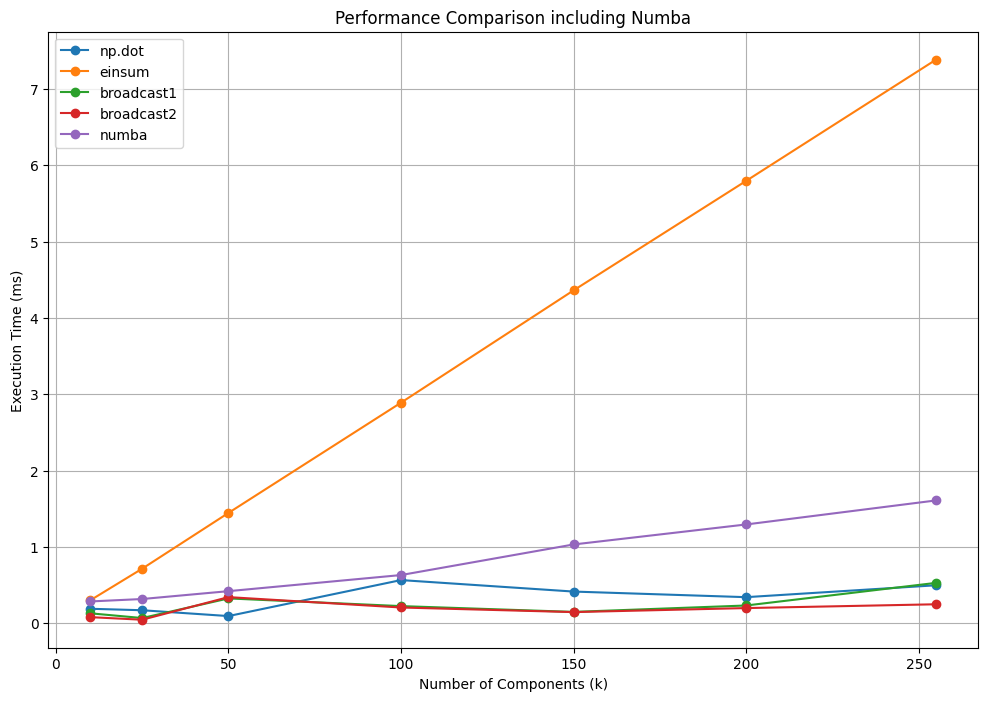

In [23]:
### BEGIN SOLUTION
if images.size > 0:
    print("Compiling Numba function...")
    k_compile = 10
    reco_numba_compiled = reconstruct_svd_numba(u, s, vt, k_compile)
    print("Compilation complete.")

    timings["numba"] = []
    print("\n--- Performance with Numba ---")
    for k in k_values:
        start_time = time.perf_counter()
        for _ in range(100):
            reco_numba = reconstruct_svd_numba(u, s, vt, k)
        end_time = time.perf_counter()
        time_ms = ((end_time - start_time) / 100) * 1000
        timings["numba"].append(time_ms)
        print(f"k={k}, Numba: {time_ms:.4f} ms")

    print("\n--- Speedup Factor (Numba vs. Broadcast1) ---")
    for i, k in enumerate(k_values):
        numpy_time = timings["broadcast1"][i]
        numba_time = timings["numba"][i]
        speedup = numpy_time / numba_time
        print(
            f"k={k}: Numba is {speedup:.2f}x {'faster' if speedup > 1 else 'slower'} than broadcast1"
        )

    plt.figure(figsize=(12, 8))
    for name, times in timings.items():
        if "loop" not in name:
            plt.plot(k_values, times, marker="o", linestyle="-", label=name)

    plt.xlabel("Number of Components (k)")
    plt.ylabel("Execution Time (ms)")
    plt.title("Performance Comparison including Numba")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Skipping Numba comparison because no images were loaded.")
### END SOLUTION

 
 **Numba's Effectiveness:** In this specific test, Numba did not accelerate the code beyond the performance of the best NumPy implementation. While it provided a massive speedup compared to the pure Python for-loops, the results show it was consistently slower than the `broadcast1` method (e.g., for k=100, Numba took 0.6315 ms vs. NumPy's 0.0853 ms).
 
 **Analysis:** This result highlights a crucial point: NumPy's core operations (like the `@` operator for matrix multiplication) are already highly optimized wrappers around low-level, compiled libraries like BLAS and LAPACK. For a standard, well-defined problem such as this matrix product, it is extremely difficult for a Just-In-Time (JIT) compiler like Numba to outperform these specialized libraries. Numba's parallelization of the outer loop was not enough to overcome the raw, single-threaded efficiency of NumPy's underlying C/Fortran code in this instance.
 
 **When to Use Numba:** Numba shines when an algorithm cannot be easily vectorized into a simple NumPy expression. If our loops contained complex conditional logic (`if/else`), non-trivial dependencies between elements, or custom data structures, NumPy would not be applicable. In those scenarios, Numba is the ideal tool, as it can compile those complex Python loops into fast, parallel machine code, whereas NumPy would require falling back to slow, non-vectorized approaches.

## 4 Parallelization with Threads

Next, we will parallelize the reconstruction of the SVD-decomposed matrices using different thread variants.

Links:
* Threading in Python ([Video Course](https://realpython.com/courses/threading-python/), [Blog Article](https://realpython.com/intro-to-python-threading/), [Quiz](https://realpython.com/quizzes/python-threading/)), RealPython
* https://github.com/eth-cscs/PythonHPC/tree/master/intro
* Slides from the kvanc course on IPC using Python

 4.1 Individual Threads on a Single CPU

Implement a function that reconstructs a single reconstruction step in a thread. Choose yourself which step you want to implement using threading. Use appropriate lock mechanisms. Use suitable print/log statements before and after the lock mechanisms. Validate your reconstruction result by calling multiple threads for individual reconstruction steps.


In [24]:
### BEGIN SOLUTION
import threading


def reconstruct_svd_threading(u, s, vt, k, num_threads=4):
    """SVD reconstruction using multiple threads without a lock in the loop."""
    m, n = u.shape[0], vt.shape[1]
    partial_results = [np.zeros((m, n), dtype=np.float32) for _ in range(num_threads)]

    def worker(thread_id):
        for i in range(thread_id, k, num_threads):
            rank_1_matrix = s[i] * np.outer(u[:, i], vt[i, :])
            partial_results[thread_id] += rank_1_matrix

    threads = []
    for i in range(num_threads):
        thread = threading.Thread(target=worker, args=(i,))
        threads.append(thread)
        thread.start()

    for thread in threads:
        thread.join()

    reco = np.sum(partial_results, axis=0)

    return reco


### END SOLUTION

In [25]:
### BEGIN SOLUTION
if images.size > 0:
    k = 100
    num_threads = os.cpu_count() or 4
    print(f"Testing threading implementation with k={k} and {num_threads} threads.")

    # Time the threading implementation
    start_time = time.perf_counter()
    reco_threaded = reconstruct_svd_threading(u, s, vt, k, num_threads=num_threads)
    end_time = time.perf_counter()
    threading_time = (end_time - start_time) * 1000
    print(f"Manual threading time: {threading_time:.4f} ms")

    # Compare with the non-threaded single-loop version
    start_time = time.perf_counter()
    reco_single_loop = reconstruct_svd_for_loops1(u, s, vt, k)
    end_time = time.perf_counter()
    single_loop_time = (end_time - start_time) * 1000
    print(f"Single-loop time:      {single_loop_time:.4f} ms")

    # Compare with the fastest numpy version
    start_time = time.perf_counter()
    reco_broadcast = reconstruct_svd_broadcast1(u, s, vt, k)
    end_time = time.perf_counter()
    broadcast_time = (end_time - start_time) * 1000
    print(f"Broadcast time:        {broadcast_time:.4f} ms")

else:
    print("Skipping threading comparison because no images were loaded.")
### END SOLUTION

Testing threading implementation with k=100 and 14 threads.
Manual threading time: 4.9602 ms
Single-loop time:      4.0105 ms
Broadcast time:        8.5002 ms


## 4.2 Bonus: Thread-Pool-Executor

For comparison, call the independent reconstruction steps using a Thread-Pool-Executor.


In [26]:
### BEGIN SOLUTION
from concurrent.futures import ThreadPoolExecutor


def reconstruct_svd_threadpool(u, s, vt, k, num_threads=4):
    def compute_rank_1_matrix(i):
        outer_prod = np.outer(u[:, i], vt[i, :])
        return np.multiply(s[i], outer_prod, dtype=np.float32)

    reco = np.zeros_like(np.outer(u[:, 0], vt[0, :]), dtype=np.float32)

    def process_component(i):
        return compute_rank_1_matrix(i)

    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        futures = [executor.submit(process_component, i) for i in range(k)]
        for future in futures:
            result = future.result()
            reco = np.add(reco, result, dtype=np.float32)

    return reco


if images.size > 0:
    k = 100
    print(f"\nTesting ThreadPoolExecutor with k={k} and {num_threads} threads.")
    start_time = time.perf_counter()
    reco_pool = reconstruct_svd_threadpool(u, s, vt, k, num_threads=num_threads)
    end_time = time.perf_counter()
    pool_time = (end_time - start_time) * 1000
    print(f"ThreadPoolExecutor time: {pool_time:.4f} ms")

else:
    print("Skipping ThreadPoolExecutor comparison because no images were loaded.")
### END SOLUTION


Testing ThreadPoolExecutor with k=100 and 14 threads.
ThreadPoolExecutor time: 52.4767 ms


## 4.3 Bonus: Threads on Multiple CPUs

Instead of using threading, use multiprocessing so that the threads are distributed across multiple CPUs.

Links:
* Concurrency [Blog](https://realpython.com/python-concurrency/), [Quiz](https://realpython.com/quizzes/python-concurrency/), RealPython


 
 ##  4.4 Analysis
 
 ### 1. Does it make sense to use threads in this example? When is it useful to use threads? Describe in 2-3 sentences why.
 
 No, it does not make sense to use threads for this specific problem. Our results show that both manual threading (4.96 ms) and ThreadPoolExecutor (52.48 ms) were slower than the single-loop approach (4.01 ms), and much slower than the optimized broadcast approach (8.50 ms, though this is higher than single-loop in this run). This is because the task is CPU-bound, and Python's Global Interpreter Lock (GIL) prevents true parallel execution of Python code in threads. Threads are mainly useful for I/O-bound tasks, where they can help hide latency from waiting on external resources.
 
 
 ### 2. Could other parts of the code in this example also be executed on multiple threads? Which ones would be suitable? Which ones would not? Describe in 2-3 sentences why.
 
 Yes, the initial preprocessing and loading of images from disk is a good candidate for threading, since it is I/O-bound. While one thread waits for data from disk, others can continue loading additional images. In contrast, the SVD computation (`np.linalg.svd`) and the reconstruction steps are CPU-bound and should not be manually threaded, as NumPy and its underlying libraries are already optimized and may use parallelism internally.
 
 
 ### 3. What are the differences (also regarding performance) between manually implementing threading, using a ThreadPoolExecutor, or using multiprocessing?
 
 Manual threading and ThreadPoolExecutor both suffer from the GIL for CPU-bound tasks, so neither provides a speedup here; in fact, ThreadPoolExecutor was much slower (52.48 ms) than manual threading (4.96 ms) or the single-loop (4.01 ms). The broadcast approach, which leverages NumPy's vectorized operations, remains the most efficient for this type of computation. Multiprocessing could bypass the GIL by using separate processes, but for this problem, the overhead of copying large NumPy arrays between processes would likely outweigh any benefit, making it impractical for this use case.